In [4]:
import torch

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [1]:
!pip install transformers accelerate datasets peft torch peft

!pip install loralib

In [14]:
import torch
import loralib as lora
import transformers
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import evaluate
import numpy as np


MODEL_NAME = "distilbert-base-uncased"
DATASET_NAME = "glue"
TASK_NAME = "sst2"
LORA_RANK = 8
LEARNING_RATE = 2e-4
BATCH_SIZE = 8
NUM_EPOCHS = 1
MAX_SAMPLES = 1000


model_hf = transformers.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
raw_datasets = load_dataset(DATASET_NAME, TASK_NAME)
metric = evaluate.load("glue", TASK_NAME)


def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding=True)

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
train_dataset = tokenized_datasets["train"].select(range(MAX_SAMPLES))
eval_dataset = tokenized_datasets["validation"].select(range(MAX_SAMPLES // 5))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [16]:
def find_and_initialize_lora_xs(model, peft_config_dict):
    for n, m in model.named_modules():
        if "LoRA" in m.__class__.__name__:
            r = m.r
            m.lora_A = torch.nn.Parameter(torch.randn(r, m.in_features) / math.sqrt(r))
            m.lora_B = torch.nn.Parameter(torch.randn(m.out_features, r) / math.sqrt(r))
            m.lora_A.requires_grad = False
            m.lora_B.requires_grad = False
            m.lora_C = torch.nn.Parameter(torch.zeros(r,r))

            for param in m.parameters():
                if param.requires_grad:
                    print(f"LoRA-XS trainable parameter: {param.shape}")



model_loraxs = transformers.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
config_loraxs = LoraConfig(
    r=LORA_RANK,
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    task_type="SEQ_CLS",
    lora_alpha=LORA_RANK,
)
model_loraxs = get_peft_model(model_loraxs, config_loraxs)


import math
find_and_initialize_lora_xs(model_loraxs, None)

training_args_loraxs = transformers.TrainingArguments(
    output_dir="./lora_xs_results",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)
trainer_loraxs = transformers.Trainer(
    model=model_loraxs,
    args=training_args_loraxs,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

print("Starting LoRA-XS training...")
trainer_loraxs.train()
metrics_loraxs = trainer_loraxs.evaluate()


num_trainable_loraxs = sum(p.numel() for p in model_loraxs.parameters() if p.requires_grad)
accuracy_loraxs = metrics_loraxs['eval_accuracy']

print(f"LoRA-XS Accuracy: {accuracy_loraxs:.4f}")
print(f"LoRA-XS Trainable Parameters: {num_trainable_loraxs}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting LoRA-XS training...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.413266,0.795000


LoRA-XS Accuracy: 0.7950
LoRA-XS Trainable Parameters: 887042


In [21]:
model_lora = transformers.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def replace_with_lora_layers(model):
    for n, m in model.named_children():
        if isinstance(m, torch.nn.Module):
            if m.__class__.__name__ == 'MultiHeadSelfAttention':
                lora_layer_q = lora.Linear(m.q_lin.in_features, m.q_lin.out_features, r=LORA_RANK)
                lora_layer_k = lora.Linear(m.k_lin.in_features, m.k_lin.out_features, r=LORA_RANK)
                lora_layer_v = lora.Linear(m.v_lin.in_features, m.v_lin.out_features, r=LORA_RANK)
                lora_layer_out = lora.Linear(m.out_lin.in_features, m.out_lin.out_features, r=LORA_RANK)
                m.q_lin = lora_layer_q
                m.k_lin = lora_layer_k
                m.v_lin = lora_layer_v
                m.out_lin = lora_layer_out
            else:
                replace_with_lora_layers(m)

replace_with_lora_layers(model_lora)

training_args_lora = transformers.TrainingArguments(
    output_dir="./lora_results",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)
trainer_lora = transformers.Trainer(
    model=model_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

print("Starting LoRA training...")
trainer_lora.train()
metrics_lora = trainer_lora.evaluate()

num_trainable_lora = sum(p.numel() for p in model_lora.parameters() if p.requires_grad)
accuracy_lora = metrics_lora['eval_accuracy']

print(f"LoRA Accuracy: {accuracy_lora:.4f}")
print(f"LoRA Trainable Parameters: {num_trainable_lora}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting LoRA training...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.429890,0.830000


LoRA Accuracy: 0.8300
LoRA Trainable Parameters: 66955010


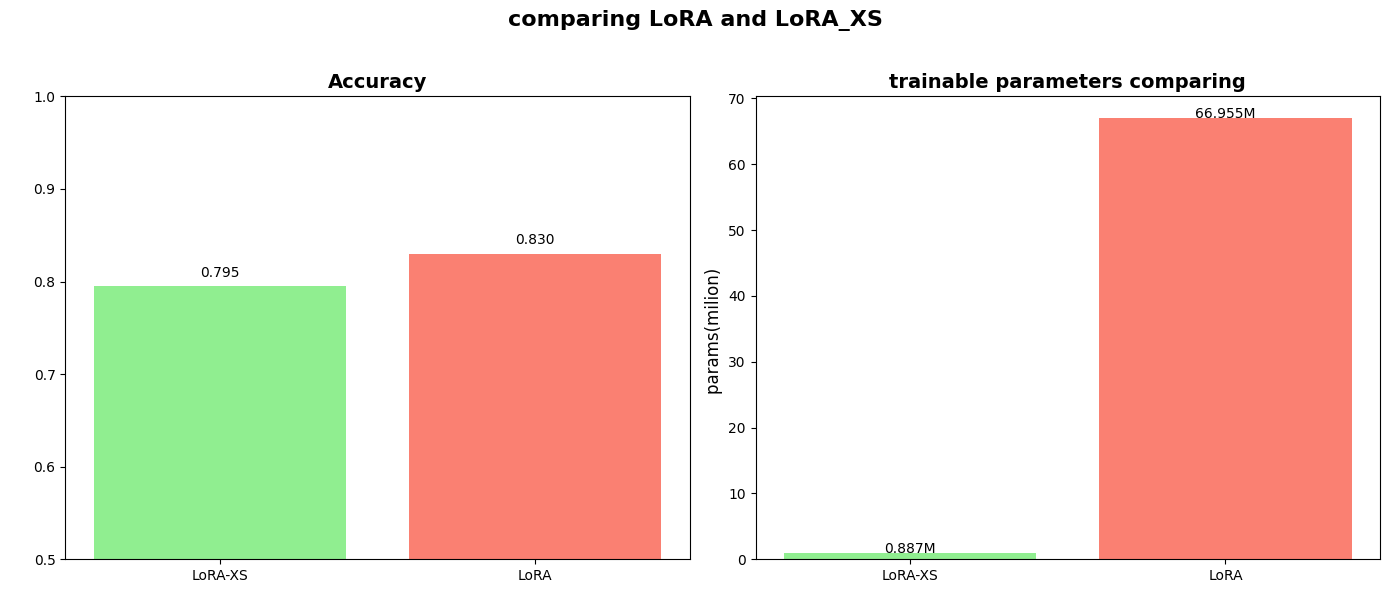

In [27]:
import matplotlib.pyplot as plt

results = {
    "LoRA-XS": {
        "accuracy": accuracy_loraxs,
        "trainable_params": num_trainable_loraxs / 1e6
    },
    "LoRA": {
        "accuracy": accuracy_lora,
        "trainable_params": num_trainable_lora / 1e6
    }
}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.bar(results.keys(), [res['accuracy'] for res in results.values()], color=['lightgreen', 'salmon'])
ax1.set_title('Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylabel(' ', fontsize=12)
ax1.set_ylim(0.5, 1.0)
for i, v in enumerate(results.values()):
    ax1.text(i, v['accuracy'] + 0.01, f"{v['accuracy']:.3f}", color='black', ha='center')

ax2.bar(results.keys(), [res['trainable_params'] for res in results.values()], color=['lightgreen', 'salmon'])
ax2.set_title('trainable parameters comparing', fontsize=14, fontweight='bold')
ax2.set_ylabel('params(milion) ', fontsize=12)
ax2.ticklabel_format(style='plain', axis='y')
for i, v in enumerate(results.values()):
    ax2.text(i, v['trainable_params'] + 0.01, f"{v['trainable_params']:.3f}M", color='black', ha='center')

plt.suptitle('comparing LoRA and LoRA_XS',fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()